# Analysis of County-Level US Presidential Election Winners

## Overview
I was tasked with creating a model to predict which party will win more votes in a county in a United States presidential election based on various demographic features of that county. This model can be used by political parties to identify emerging counties of interest in the lead-up to an election to help guide their decisions on where to allocate advertising, field organizing, and other resources.

I used county-level demographic and presidential election data from the US Census Bureau and MIT Election Data + Science Lab that had been consolidated into a single dataset on Kaggle. The data included information from four presidential elections (2008, 2012, 2016, and 2020), each of which took place in a different national political context and with varying levels of national election turnout.

When building my models, I prioritized maximizing recall (to avoid "false negatives" - counties that we predicted would vote Democratic but actually voted Republican) to minimize the chance that we would lose a county that we expected to win - a result that may cost us a national election. I also prioritized accuracy, because each incorrect prediction in either direction may cost us valuable campaign dollars or electoral votes.

[MODEL DESCRIPTION]

[CONCLUSION]

## Business Problem
Despite winning three of the last four presidential elections, the Democratic Party in the United States faces a perilous political future. A [small number of states](https://www.cnn.com/2022/11/22/politics/2022-preview-2024-presidential-election/index.html) hold the key to swinging any given presidential contest. The near-inverse results of the 2016 and 2020 elections in terms of total electoral college votes despite [small swings in the popular vote margins of these states](https://www.washingtonpost.com/elections/election-results/president-2020/) demonstrates the importance of allocating campaign resources efficiently.

The 2020 election proved that the Democratic Party can return states it had lost in 2016 to its column (Michigan, Wisconsin, Pennsylvania) while simultaneously picking up new states for the first time since the 1990s (Arizona, Georgia). In order to protect these gains, and expand the electoral map to open new opportunities, the party must have an understanding of what factors make a state likely to tip to one party or the other in the coming years.

I chose to conduct my analysis at the county level because while presidential elections are decided at the state level, political parties build operations (such as "get out the vote" efforts and digital advertising campaigns) that target voters at the most granular geographic level possible and need information to guide these decisions. Additionally, these predictions are only meant to be one piece of the puzzle - they can be put in the broader political context of the state and nation as part of the process of developing a comprehensive campaign strategy. 

By building a predictive model to project the winner of presidential elections at the county level, the party can better understand what factors make a given area likely to vote one way or the other in coming elections. It can use this knowledge to guide its investments in emerging fertile areas or to shore up states that are at risk of slipping away.

In [77]:
# Standard Packages
import pandas as pd
import numpy as np

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Scipy Stats
import scipy.stats as stats

# SKLearn Modules
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize, PolynomialFeatures, LabelEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, log_loss, plot_confusion_matrix, plot_roc_curve, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectFromModel

# XGBoost modules
from xgboost import XGBClassifier

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable
pd.options.display.max_columns = None
pd.options.display.width = None

# Data

I used [data from the US Census Bureau and MIT Election Data + Science Lab](https://www.kaggle.com/datasets/minhbtnguyen/us-census-for-election-predictions-20002020) that had been consolidated into a single dataset on Kaggle. The data included information from four presidential elections (2008, 2012, 2016, and 2020), each of which took place in a different national political context and with varying levels of national election turnout. The dataset also includes a variety of descriptive demographic statistics such as average income, average age, gender, race, education attainment, and other factors [associated with voting behavior.](https://www.icpsr.umich.edu/web/pages/instructors/setups/voting.html)

In [3]:
# load the dataset
census_data = pd.read_csv('data/county_census_and_election_result.csv')
census_data

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2000,1,24566.4,634.6,46.0,46912.7,93.6,6.4,54.0,46.0,8.9,16.8,59.1,11.5,2.3,1.3,77.1,20.0,0.6,1.0,0.1,0.7,0.4,0.0,0.0,97.3,1.5,1.1,96.5,3.5,41.0,51.9,6.4,0.7,58.4,38.4,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,2,33842.9,1080.1,42.4,65021.9,95.3,4.7,50.3,49.7,4.1,18.0,61.1,13.4,1.7,1.6,80.5,2.7,0.6,2.5,0.3,3.6,9.1,0.4,0.2,92.6,2.8,4.6,89.4,10.6,53.1,36.5,8.9,1.5,70.0,25.2,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,4,28331.7,814.7,45.3,52826.7,95.8,4.2,52.1,47.9,6.7,20.8,57.1,11.5,2.0,1.8,84.7,2.4,6.2,1.7,0.2,1.4,2.6,0.7,0.0,86.8,8.3,4.8,79.4,20.6,48.4,43.3,7.5,0.8,58.4,38.3,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,5,22782.6,557.5,46.2,43941.3,92.5,7.5,53.0,47.0,9.5,15.6,60.6,10.9,2.2,1.1,85.7,10.8,0.8,1.2,0.1,0.5,0.7,0.1,0.0,98.0,1.0,1.1,96.8,3.2,38.3,55.7,5.2,0.8,59.1,37.8,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,6,32245.0,1216.3,43.8,61455.3,95.7,4.3,52.0,48.0,6.4,24.5,53.7,10.6,2.4,2.5,70.5,5.4,7.9,2.6,1.3,7.8,0.9,3.5,0.2,70.9,15.2,13.9,65.6,34.4,50.2,40.1,8.5,1.2,61.4,35.1,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [4]:
# initial look at data
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7526 entries, 0 to 7525
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  7526 non-null   int64  
 1   county_fips           7526 non-null   int64  
 2   inctot                7526 non-null   float64
 3   mortamt1              7526 non-null   float64
 4   avrg_age              7526 non-null   float64
 5   ftotinc               7526 non-null   float64
 6   foodstmp_1_freq       7526 non-null   float64
 7   foodstmp_2_freq       7526 non-null   float64
 8   sex_2_freq            7526 non-null   float64
 9   sex_1_freq            7526 non-null   float64
 10  marst_5_freq          7526 non-null   float64
 11  marst_6_freq          7526 non-null   float64
 12  marst_1_freq          7526 non-null   float64
 13  marst_4_freq          7526 non-null   float64
 14  marst_3_freq          7526 non-null   float64
 15  marst_2_freq         

In [5]:
# initial look at descriptive stats of numeric values
census_data.describe()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
count,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,7526.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000
mean,2012.369253,27810.761228,28325.447077,884.343848,46.748220,57025.384999,90.560404,9.439596,51.956683,48.043317,6.880880,24.536606,53.739596,11.112437,1.772256,1.957720,80.788759,9.406551,2.728966,1.990194,0.265334,2.807786,0.974409,0.833285,0.208411,89.553734,5.097024,5.349641,85.797250,14.202750,48.947263,40.487164,9.304026,1.261175,58.670648,37.460218,3.869280,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623
std,4.916645,16197.855610,6973.567827,284.898492,2.641396,13720.562319,4.974988,4.974988,1.708150,1.708106,1.519885,6.726603,7.220689,1.966797,0.782685,0.772832,13.860190,10.505817,3.678845,2.287334,1.323770,3.698773,3.112997,1.698069,0.639464,9.207069,4.557111,5.120796,12.934326,12.934326,6.093376,9.266526,4.175560,0.919959,6.223587,5.988654,1.557713,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020
min,2000.000000,1.000000,14165.200000,397.100000,36.100000,31193.400000,58.000000,0.400000,33.400000,38.400000,2.400000,10.100000,25.700000,5.300000,0.000000,0.200000,18.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.400000,0.000000,0.000000,5.700000,0.900000,25.600000,11.100000,2.000000,0.000000,30.700000,20.300000,0.300000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000
25%,2008.000000,13021.000000,23549.800000,680.125000,45.200000,47305.025000,87.700000,5.800000,51.100000,47.000000,5.800000,19.800000,49.400000,9.700000,1.200000,1.500000,74.400000,2.200000,0.700000,1.000000,0.000000,0.900000,0.200000,0.100000,0.000000,87.000000,2.000000,2.000000,82.300000,5.900000,45.000000,34.025000,6.300000,0.700000,54.900000,33.400000,2.700000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000
50%,2013.000000,28000.000000,26843.600000,808.200000,46.700000,53615.350000,91.200000,8.800000,52.100000,47.900000,6.800000,23.500000,54.200000,11.100000,1.700000,1.800000,84.300000,5.700000,1.400000,1.400000,0.100000,1.700000,0.300000,0.400000,0.100000,92.600000,3.500000,3.500000,90.500000,9.500000,49.100000,40.500000,8.500000,1.000000,59.200000,36.800000,3.600000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000
75%,2017.000000,42000.000000,31579.250000,1019.500000,48.200000,63757.000000,94.200000,12.300000,53.000000,48.900000,7.900000,27.900000,58.800000,12.400000,2.200000,2.300000,91.300000,12.700000,3.200000,2.100000,0.200000,3.200000,0.700000,0.800000,0.200000,95.700000,6.500000,6.700000,94.100000,17.700000,53.000000,47.000000,11.300000,1.500000,63.000000,41.000000,4.700000,1.281622e+05,0.000000,0.000000,4808.250000,1.002938e+05,1.000000
max,2020.000000,56000.000000,68229.100000,2080.900000,59.600000,137573.700000,99.600000,42.000000,61.600000,66.600000,14.700000,54.200000,76.100000,19.500000,6.600000,8.800000,99.000000,66.400000,38.700000,53.000000,23.500000,34.400000,49.400000,23.100000,14.400000,99.900000,29.600000,35.200000,99.100000,94.300000,69.300000,69.700000,

There are a lot of missing rows in some of our columns, but that makes sense since this dataset includes information from many more years than just presidential election years. 

## Data Preparation
We're only interested in rows that have both presidential election results **and** demographic information. Let's start by dropping rows from non-presidential election years (including 2000 and 2004 since this dataset doesn't include voting data from those elections) to see what kind of missingness remains.

In [6]:
# define presidential years and only include records from those years
pres_years = [2008, 2012, 2016, 2020]
pres_df = census_data[census_data['year'].isin(pres_years)]
pres_df

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
1528,2008,1000,22523.9,591.8,47.0,44879.5,90.6,9.4,53.4,46.6,9.5,17.4,56.4,12.4,2.6,1.8,77.0,20.0,0.6,1.0,0.1,0.5,0.6,0.1,0.1,97.0,1.9,1.0,96.4,3.6,40.4,53.3,5.9,0.5,54.9,41.6,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1530,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
1531,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
1532,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
7522,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
7523,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0
7524,2020,55139,25796.1,667.3,45.9,49219.4,93.5,6.5,47.9,52.1,6.7,28.2,50.3,12.4,1.0,1.5,89.7,3.9,0.5,3.8,0.0,1.6,0.3,0.1,0.2,97.7,0.7,1.6,96.1,3.9,51.1,41.3,7.2,0.4,56.9,41.5,1.6,WI,WINNEBAGO,44060.0,38.0,1629.0,509.0,47796.0,1.0


In [7]:
# check info of data
pres_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1858 entries, 1528 to 7525
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1858 non-null   int64  
 1   county_fips           1858 non-null   int64  
 2   inctot                1858 non-null   float64
 3   mortamt1              1858 non-null   float64
 4   avrg_age              1858 non-null   float64
 5   ftotinc               1858 non-null   float64
 6   foodstmp_1_freq       1858 non-null   float64
 7   foodstmp_2_freq       1858 non-null   float64
 8   sex_2_freq            1858 non-null   float64
 9   sex_1_freq            1858 non-null   float64
 10  marst_5_freq          1858 non-null   float64
 11  marst_6_freq          1858 non-null   float64
 12  marst_1_freq          1858 non-null   float64
 13  marst_4_freq          1858 non-null   float64
 14  marst_3_freq          1858 non-null   float64
 15  marst_2_freq      

Unfortunately, we still have about 200 missing rows in our election results columns. Because our analysis requires precise adherence to actual election outcomes, there is no imputation strategy that will allow us to fill in these values without substantially diluting the value of our recommendations. We will drop these rows to ensure that we have a complete, accurate set of information for each row.

In [8]:
# drop NAs and reset index
pres_df.dropna(inplace = True)
pres_df.reset_index(drop = True, inplace = True)
pres_df

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,state_po,county_name,democrat,green,liberitarian,other,republican,winner
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0
4,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,51.2,8.3,1.7,2.0,75.2,21.0,0.3,0.6,0.1,1.7,0.3,0.8,0.2,94.4,4.1,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,21498.0,0.0,0.0,597.0,32230.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,2020,55105,25993.3,657.3,49.1,54440.5,91.6,8.4,51.3,48.7,7.4,27.4,49.9,13.0,0.4,1.9,89.4,3.3,1.3,4.4,0.1,0.2,0.3,0.4,0.5,96.2,1.1,2.7,96.6,3.4,51.4,40.3,7.4,0.8,53.4,43.2,3.4,WI,ROCK,46658.0,14.0,1094.0,456.0,37138.0,0.0
1666,2020,55117,26884.0,704.0,50.3,52592.7,95.6,4.4,49.5,50.5,7.3,24.2,57.1,9.4,0.9,1.1,89.7,3.1,1.1,3.4,0.3,1.9,0.1,0.1,0.2,96.4,1.7,1.8,94.4,5.6,50.9,40.7,7.8,0.6,56.3,42.3,1.4,WI,SHEBOYGAN,27101.0,2.0,896.0,403.0,37609.0,1.0
1667,2020,55127,28065.5,846.0,49.0,63315.2,94.9,5.1,49.4,50.6,5.9,26.8,56.6,8.1,0.6,2.0,91.5,0.6,3.3,2.7,0.0,0.1,0.9,0.8,0.0,93.2,2.4,4.4,91.4,8.6,56.1,33.2,9.1,1.7,61.6,37.6,0.8,WI,WALWORTH,22789.0,15.0,641.0,304.0,33851.0,1.0
1668,2020,55133,38557.0,990.6,50.4,80433.1,95.9,4.1,52.8,47.2,7.4,20.0,61.5,9.4,0.3,1.4,91.3,1.4,1.2,3.3,0.1,2.3,0.2,0.2,0.1,94.3,2.1,3.5,93.1,6.9,59.8,26.5,12.9,0.8,60.7,37.3,2.0,WI,WAUKESHA,103906.0,54.0,3023.0,1364.0,159649.0,1.0


In [9]:
# inspect cleaned data info
pres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 45 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  1670 non-null   int64  
 1   county_fips           1670 non-null   int64  
 2   inctot                1670 non-null   float64
 3   mortamt1              1670 non-null   float64
 4   avrg_age              1670 non-null   float64
 5   ftotinc               1670 non-null   float64
 6   foodstmp_1_freq       1670 non-null   float64
 7   foodstmp_2_freq       1670 non-null   float64
 8   sex_2_freq            1670 non-null   float64
 9   sex_1_freq            1670 non-null   float64
 10  marst_5_freq          1670 non-null   float64
 11  marst_6_freq          1670 non-null   float64
 12  marst_1_freq          1670 non-null   float64
 13  marst_4_freq          1670 non-null   float64
 14  marst_3_freq          1670 non-null   float64
 15  marst_2_freq         

In [10]:
# inspect cleaned data descriptive stats
pres_df.describe()

,year,county_fips,inctot,mortamt1,avrg_age,ftotinc,foodstmp_1_freq,foodstmp_2_freq,sex_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_1_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_1_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_1_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_1_freq,lang_2_freq,educ_attain_2.0_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_1.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000
mean,2014.194012,28717.220958,28841.084850,906.672635,46.903772,58749.243473,90.251257,9.748743,51.855629,48.144371,6.777066,25.837186,52.495150,11.105329,1.721317,2.062275,78.738683,9.917784,2.978862,3.136048,0.235689,3.035150,0.759401,0.928862,0.272455,88.969461,5.269042,5.761198,85.102335,14.897665,49.909222,38.882335,9.860778,1.347904,58.226347,38.028922,3.745689,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623
std,4.410969,15595.725527,7295.609512,291.128525,2.787388,14606.621299,4.952513,4.952513,1.830548,1.830548,1.559419,7.176813,7.509596,2.044045,0.766393,0.795502,14.646107,10.614890,3.912003,3.870875,1.090427,3.688328,2.406652,1.840668,0.680919,9.457760,4.631289,5.320845,13.393902,13.393902,5.909867,9.208955,4.384230,0.979554,6.558229,6.335632,1.373302,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020
min,2008.000000,1003.000000,14897.300000,421.100000,36.700000,34914.700000,65.600000,0.900000,33.400000,42.000000,2.500000,11.600000,26.800000,5.600000,0.000000,0.500000,18.600000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,44.800000,0.000000,0.000000,6.900000,1.400000,25.600000,13.000000,2.300000,0.000000,30.700000,20.800000,0.800000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000
25%,2012.000000,13135.000000,23894.650000,698.025000,45.200000,48357.400000,87.300000,6.100000,51.000000,47.100000,5.700000,20.900000,48.000000,9.625000,1.200000,1.500000,71.425000,2.625000,0.725000,1.100000,0.000000,1.000000,0.200000,0.200000,0.100000,86.400000,2.125000,2.200000,81.400000,6.200000,46.100000,32.300000,6.700000,0.700000,54.300000,33.700000,2.800000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000
50%,2016.000000,29099.000000,27351.850000,828.550000,46.900000,55458.800000,90.900000,9.100000,52.000000,48.000000,6.700000,24.900000,52.800000,11.100000,1.600000,1.950000,82.600000,6.400000,1.600000,1.700000,0.100000,1.900000,0.300000,0.400000,0.200000,92.200000,3.600000,3.900000,89.900000,10.100000,50.000000,38.800000,9.100000,1.100000,58.700000,37.500000,3.500000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000
75%,2020.000000,42018.500000,32176.200000,1039.600000,48.400000,66187.150000,93.900000,12.700000,52.900000,49.000000,7.700000,29.400000,57.600000,12.400000,2.200000,2.500000,89.700000,13.300000,3.600000,3.700000,0.200000,3.600000,0.700000,0.900000,0.300000,95.300000,6.900000,7.300000,93.800000,18.600000,54.000000,45.475000,12.100000,1.700000,62.800000,41.700000,4.500000,1.281622e+05,0.000000,0.000000,4808.250000,1.002938e+05,1.000000
max,2020.000000,55139.000000,68229.100000,2064.600000,59.400000,137573.700000,99.100000,34.400000,58.000000,66.600000,14.700000,54.100000,74.800000,19.500000,5.800000,8.500000,99.000000,65.400000,38.700000,53.000000,20.100000,33.700000,42.900000,23.100000,14.400000,99.900000,28.200000,34.600000,98.600000,93.100000,68.600000,69.700

From this initial examination it appears that we will have to drop some columns to avoid issues of multicollinearity. For example, for every row, the values of "sex_2_freq" and "sex_1_freq" will sum to 100%:

In [11]:
# checking that sum of those two columns = 100 for all rows
gender_check = pres_df.loc[pres_df['sex_2_freq'] + pres_df['sex_1_freq'] == 100]
assert gender_check.shape[0] == pres_df.shape[0]

The same goes for each discrete category of demographic information included - foodstamp frequency, gender, marriage status, race, citizenship, language spoken, educational attainment, and employment. Having perfectly (or even near-perfectly) correlated variables such as these in our data will make our model less powerful by artificially inflating its variance. 

In order to avoid multicollinearity, we will drop the column with the highest mean (which means it has the highest average proportion) from each category to serve as the "baseline" for our analysis. We can also drop the year, County FIP Code, state_po, and county_name columns since they will not be used in our analysis for now.

In [12]:
# drop columns
todrop = ['year',
          'county_fips', 
          'foodstmp_1_freq',
          'sex_2_freq',
          'marst_1_freq',
          'race_1_freq',
          'ctz_stat_1_freq',
          'lang_1_freq',
          'educ_attain_2.0_freq',
          'empstat_1.0_freq',
          'state_po',
          'county_name']

pres_df_binary = pres_df.drop(todrop, axis = 1)
pres_df_binary.head(2)

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,democrat,green,liberitarian,other,republican,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,39.3,8.4,0.5,43.5,2.4,19386.0,0.0,0.0,756.0,61271.0,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,52.6,5.0,1.2,41.1,4.5,16334.0,0.0,0.0,560.0,32348.0,1.0


In [13]:
# check that they're gone
assert not any(col in pres_df_binary.columns for col in todrop)

Additionally, in order to create a model of the relationship between the demographics of each county and the winner, we need to eliminate the actual vote totals for each county from our dataframe. These vote counts are a significant source of potential data leakage in any model, since they would not be known at the time our prediction is made.

In [14]:
# drop columns with vote counts
votecounts = ['democrat',
              'green', 
              'liberitarian',
              'other',
              'republican']

pres_df_binary.drop(votecounts, inplace = True, axis = 1)
pres_df_binary.head(2)

,inctot,mortamt1,avrg_age,ftotinc,foodstmp_2_freq,sex_1_freq,marst_5_freq,marst_6_freq,marst_4_freq,marst_3_freq,marst_2_freq,race_2_freq,race_7_freq,race_8_freq,race_5_freq,race_6_freq,race_3_freq,race_4_freq,race_9_freq,ctz_stat_3_freq,ctz_stat_2_freq,lang_2_freq,educ_attain_1.0_freq,educ_attain_3.0_freq,educ_attain_4.0_freq,empstat_3.0_freq,empstat_2.0_freq,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,39.3,8.4,0.5,43.5,2.4,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,52.6,5.0,1.2,41.1,4.5,1.0


Now that we have a complete dataset, we need to take a look at the descriptive statistics to see if there are any obvious outliers or data entry errors. These column headers are difficult to interpret - let's replace them with their description from the metadata included with the data to make it simpler to understand.

In [15]:
# load descriptions and create a dictionary with original column names and their description
descriptions = pd.read_csv('data/meta_data.csv')
descriptions_dict = dict(zip(descriptions['Column'], descriptions['Description']))
descriptions_dict

{'year': 'Year',
 'county_fips': 'County FIP Code',
 'inctot': 'Average Annual Income of Individuals',
 'mortamt1': 'Average Amount Of Mortgage Payments',
 'avrg_age': 'Average Age',
 'ftotinc': 'Average Annual Total Family Income',
 'foodstmp_1_freq': '% of Individuals Who Did Not Receive Foodstamps',
 'foodstmp_2_freq': '% of Individuals Who Received Foodstamps',
 'sex_2_freq': '% of Females',
 'sex_1_freq': '% of Males',
 'marst_5_freq': '% Widowed',
 'marst_6_freq': '% Never Married',
 'marst_1_freq': '% Married Spouse Present',
 'marst_4_freq': '% Divorced',
 'marst_3_freq': '% Seperated',
 'marst_2_freq': '% Married Spouse Absent',
 'race_1_freq': '% White',
 'race_2_freq': '% Black/African American',
 'race_7_freq': '% Other Race',
 'race_8_freq': '% Two major Races',
 'race_5_freq': '% Japanese',
 'race_6_freq': '% Other Asian',
 'race_3_freq': '% American Indian or Alaska Native',
 'race_4_freq': '% Chinese',
 'race_9_freq': '% Three or More Races',
 'ctz_stat_1_freq': '% Citi

In [16]:
# rename columns using descriptions
pres_df_binary.rename(columns=descriptions_dict, inplace=True)
pres_df_binary.head(2)

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed,winner
0,27222.4,902.2,48.6,53308.6,5.8,47.5,8.3,12.1,13.2,1.3,1.6,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,1.3,1.6,2.9,39.3,8.4,0.5,43.5,2.4,1.0
1,20951.6,551.7,47.1,39712.5,10.9,45.2,8.7,19.5,11.5,3.0,2.8,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,1.5,1.2,4.6,52.6,5.0,1.2,41.1,4.5,1.0


In [17]:
# check descriptive stats with more interpretable column names
pres_df_binary.describe()

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed,winner
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,28841.084850,906.672635,46.903772,58749.243473,9.748743,48.144371,6.777066,25.837186,11.105329,1.721317,2.062275,9.917784,2.978862,3.136048,0.235689,3.035150,0.759401,0.928862,0.272455,5.269042,5.761198,14.897665,38.882335,9.860778,1.347904,38.028922,3.745689,0.488623
std,7295.609512,291.128525,2.787388,14606.621299,4.952513,1.830548,1.559419,7.176813,2.044045,0.766393,0.795502,10.614890,3.912003,3.870875,1.090427,3.688328,2.406652,1.840668,0.680919,4.631289,5.320845,13.393902,9.208955,4.384230,0.979554,6.335632,1.373302,0.500020
min,14897.300000,421.100000,36.700000,34914.700000,0.900000,42.000000,2.500000,11.600000,5.600000,0.000000,0.500000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,13.000000,2.300000,0.000000,20.800000,0.800000,0.000000
25%,23894.650000,698.025000,45.200000,48357.400000,6.100000,47.100000,5.700000,20.900000,9.625000,1.200000,1.500000,2.625000,0.725000,1.100000,0.000000,1.000000,0.200000,0.200000,0.100000,2.125000,2.200000,6.200000,32.300000,6.700000,0.700000,33.700000,2.800000,0.000000
50%,27351.850000,828.550000,46.900000,55458.800000,9.100000,48.000000,6.700000,24.900000,11.100000,1.600000,1.950000,6.400000,1.600000,1.700000,0.100000,1.900000,0.300000,0.400000,0.200000,3.600000,3.900000,10.100000,38.800000,9.100000,1.100000,37.500000,3.500000,0.000000
75%,32176.200000,1039.600000,48.400000,66187.150000,12.700000,49.000000,7.700000,29.400000,12.400000,2.200000,2.500000,13.300000,3.600000,3.700000,0.200000,3.600000,0.700000,0.900000,0.300000,6.900000,7.300000,18.600000,45.475000,12.100000,1.700000,41.700000,4.500000,1.000000
max,68229.100000,2064.600000,59.400000,137573.700000,34.400000,66.600000,14.700000,54.100000,19.500000,5.800000,8.500000,65.400000,38.700000,53.000000,20.100000,33.700000,42.900000,23.100000,14.400000,28.200000,34.600000,93.100000,69.700000,36.600000,7.500000,67.200000,10.400000,1.000000


From examining the head of the data and the descriptive statistics, there are a couple of observations we can make:
- Our variables are on different orders of magnitude. Average individual and family income are in the 10s of thousands; mortgage payments are in the hundreds of thousands; the remainder of the variables are in the ones or tens. We'll need to scale these variables to close the distance between them.
- There are some potential outliers (such as the county where only 6.9% of people speak English at home, or the county where over 67% of the population is not in the labor force).
- These counties have a diverse set of demographic characteristics along a variety of lines of difference, such as race, marriage status, language spoken at home, and more.

Let's examine the distribution of each column to check for potential outliers and skew:

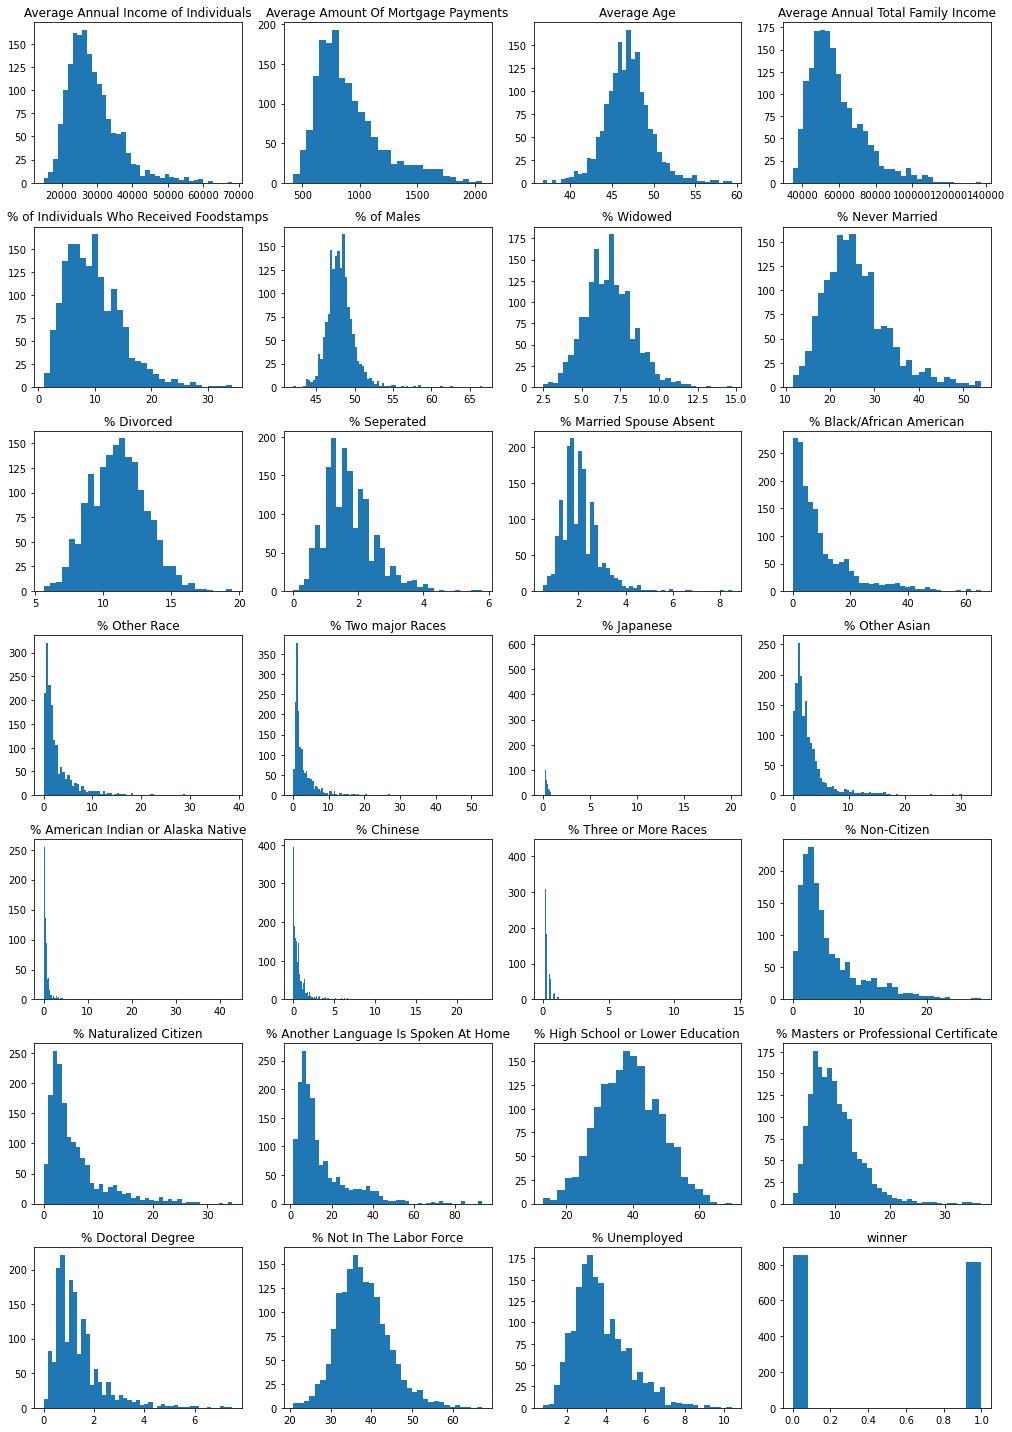

In [18]:
# set up figure for remaining predictor variables in X_third
fig, axes = plt.subplots(nrows=(pres_df_binary.shape[1] // 4), ncols=4, figsize=(14,20))

# for each col in pres_df_binary, plot distribution
for col, ax in zip(pres_df_binary, axes.flatten()):
    ax.hist(pres_df_binary[col], bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

It looks like most of our  variables are either normally distributed or skewed to the right. We can also see that we do not have a substantial class imbalance - the number of counties won by the Democrat (0) and Republican (1) are nearly equal. 

When the time comes to build our model, we'll need to scale and/or transform these columns to bring the orders of magnitude into line and ensure that the distributions are as close to normal as possible.

In [19]:
# checking skew
skew_dict = {col: pres_df_binary[col].skew() for col in pres_df_binary.columns}
sorted(skew_dict.items(), key = lambda x: x[1], reverse = True)

[('% Japanese', 14.225645376417823),
 ('% Three or More Races', 12.958995759654524),
 ('% American Indian or Alaska Native', 12.27393163370858),
 ('% Chinese', 6.117955414893402),
 ('% Two major Races', 4.431729634988505),
 ('% Other Asian', 3.528662241008241),
 ('% Other Race', 3.3196618422536543),
 ('% Another Language Is Spoken At Home', 2.1372927643249713),
 ('% Doctoral Degree', 2.0947227321666024),
 ('% Black/African American', 1.9984005385580035),
 ('% Naturalized Citizen', 1.957434023575899),
 ('% of Males', 1.8348877524676177),
 ('% Married Spouse Absent', 1.7166976573230215),
 ('% Non-Citizen', 1.6925120055089615),
 ('% Masters or Professional Certificate', 1.5473773140107256),
 ('Average Annual Income of Individuals', 1.3717823754930822),
 ('Average Annual Total Family Income', 1.2381474444602085),
 ('Average Amount Of Mortgage Payments', 1.1783968298185061),
 ('% of Individuals Who Received Foodstamps', 0.9988343531328995),
 ('% Unemployed', 0.9564741625539154),
 ('% Never 

Let's also check to see what correlations exist among our variables with a heatmap.

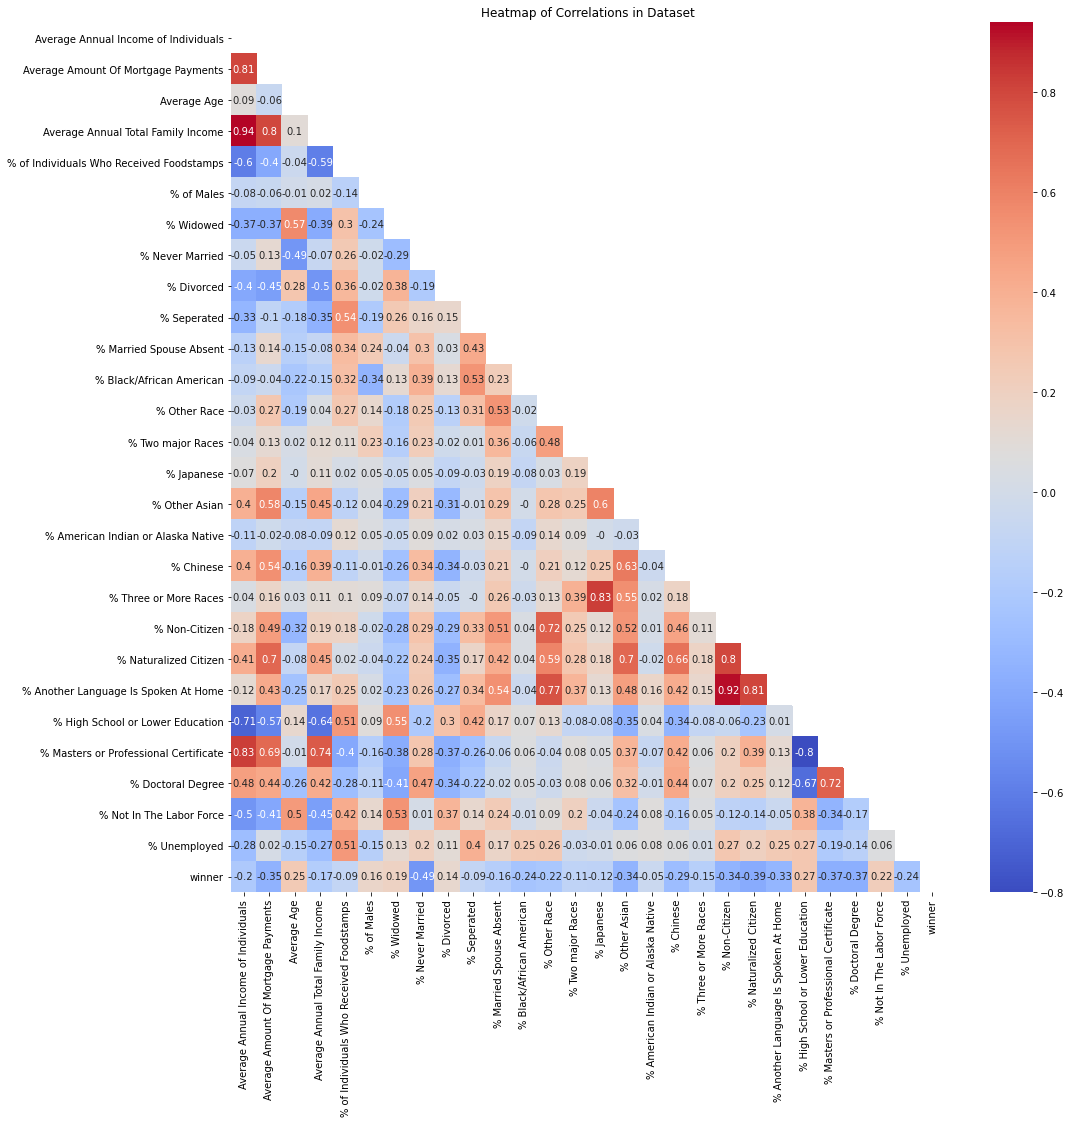

In [20]:
# instantiate figure
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = round(pres_df_binary.corr(), 2)

# create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plot figure
sns.heatmap(corr, cmap = 'coolwarm', annot = True, mask = mask)

# Customize the plot appearance
ax.set_title("Heatmap of Correlations in Dataset");

plt.show()

There are some notable correlations between categories (such as % Masters or Professional Certificate and Average Annual Income of Individuals, or % Another Language Is Spoken At Home and % Non-Citizen), and a relatively high degree of correlation among variables in the same category. However, for now, we can hold off on removing any more columns from our dataset until we have a baseline model to evaluate and iterate on.

Finally, let's see what the relationships look like between our "winner" column and our features:

In [27]:
# separate X and y
X = pres_df_binary.drop('winner', axis = 1)
y = pres_df_binary['winner']

# sns.pairplot(hue = 'winner',
#              vars = X,
#              data = pres_df_binary,
#              corner = True)

## Baseline Model: Logistic Regression

Let's begin by creating a baseline logistic regression model without transforming any of our features. We'll start by splitting our data into train and test sets, with 25% of our rows set aside as a test set for evaluation. That will leave around 1200 rows for training our model, while preserving 400 to test its performance on unseen data to help us avoid overfitting and underfitting.

In [28]:
# split into train and test sets with a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 270)

In [29]:
# examine head of feature df
X_train.head()

,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Received Foodstamps,% of Males,% Widowed,% Never Married,% Divorced,% Seperated,% Married Spouse Absent,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Non-Citizen,% Naturalized Citizen,% Another Language Is Spoken At Home,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Not In The Labor Force,% Unemployed
1292,35446.8,1048.7,49.0,70306.8,9.9,47.9,7.1,31.1,10.5,1.0,2.1,10.7,5.1,6.6,0.1,4.5,0.2,0.6,0.5,6.0,10.7,21.2,33.9,15.9,2.0,38.6,3.6
228,28553.2,703.6,47.7,56406.1,4.1,48.6,7.8,20.0,11.9,1.5,1.5,0.9,0.2,1.1,0.1,0.1,0.1,0.4,0.0,0.6,2.4,4.1,36.5,11.2,0.6,30.0,3.6
298,21456.8,544.2,49.6,45210.0,6.2,49.9,10.7,22.0,10.5,2.2,2.1,3.0,0.1,0.5,0.0,0.6,0.0,0.0,0.0,0.6,1.0,4.4,62.7,5.4,0.8,41.9,2.4
36,33057.2,1546.5,44.3,64583.2,3.1,49.0,5.8,27.1,10.9,1.9,2.8,4.0,5.9,2.7,0.7,9.6,1.0,1.7,0.2,11.9,14.4,32.3,33.2,10.7,1.9,33.2,4.0
335,26268.5,758.5,44.7,56052.4,6.7,49.5,6.8,15.5,10.7,1.8,2.2,1.7,2.8,1.3,0.0,0.7,0.4,0.2,0.1,5.1,1.6,11.9,52.6,4.1,0.5,34.4,3.0


In [30]:
# 1 means the Republican won, 0 means the Democrat won
y_train.head()

1292    0.0
228     1.0
298     1.0
36      0.0
335     1.0
Name: winner, dtype: float64

In [31]:
# make sure nothing went wrong
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

We'll use a pipeline to minimize the risk of data leakage in our baseline, and use a standard scaler to transform the values to ensure they're all on the same order of magnitude. We'll also use a five fold cross validation to minimize the risk of overfitting on the training data.

In [32]:
# instantiate pipeline
baseline_pipe = Pipeline([('scaler', StandardScaler()),
                  ('lr', LogisticRegression(max_iter = 2000))])

# fit pipeline
baseline_pipe.fit(X_train, y_train)

baseline_scores = cross_val_score(baseline_pipe, X_train, y_train, cv=5)
print("Mean cross-validation score:", baseline_scores.mean())

Mean cross-validation score: 0.8314613545816734


Looks like our model is performing okay for now - about 83% accuracy on our validation folds. Let's see how it performs on test data.

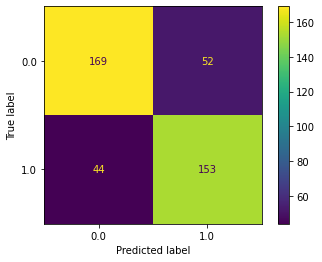

In [33]:
# generate predictions
y_baseline_preds = baseline_pipe.predict(X_test)

# plot confusion matrix
plot_confusion_matrix(baseline_pipe, X_test, y_test);

In [34]:
# print classification report for closer examination
print(classification_report(y_test, y_baseline_preds))

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78       221
         1.0       0.75      0.78      0.76       197

    accuracy                           0.77       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.77      0.77      0.77       418



Overall our baseline model performs okay on unseen data, but not nearly at the level we need to guide national campaign-level decision-making. We want to be accurate overall, but in the context of this model, a false negative (where we predicted that a county would vote Democratic but it voted Republican) is a much worse outcome for us than a false positive (where we predicted that a county would vote Republican but it voted Democratic). False positives may cost us money in campaign dollars, but false negatives can cost us elections!

Consequently, we're hoping to minimize our false negatives and maximize our recall. For this baseline, our accuracy and recall are both 77%, meaning only about 77% of our predicted outcomes are accurate and we're only capturing about 77% of the actual number of Republican victories in our data. For subsequent models, we'll try different preprocessing and modeling techniques that may be able to increase these values.

## Model 2: Decision Tree

Let's test a few more baseline models before we hone in on one to tune. We'll try a decision tree next - decision trees are great for complex datasets because it splits the data one feature at a time, which will also help us to identify which features are the most important in making predictions about the partisan outcome of a county. We'll use Gini inpurity to measure information gain because we want to heavily penalize heterogeneity in our leaves.

In [35]:
baseline_tree = DecisionTreeClassifier(criterion = 'gini', random_state = 270)
baseline_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=270)

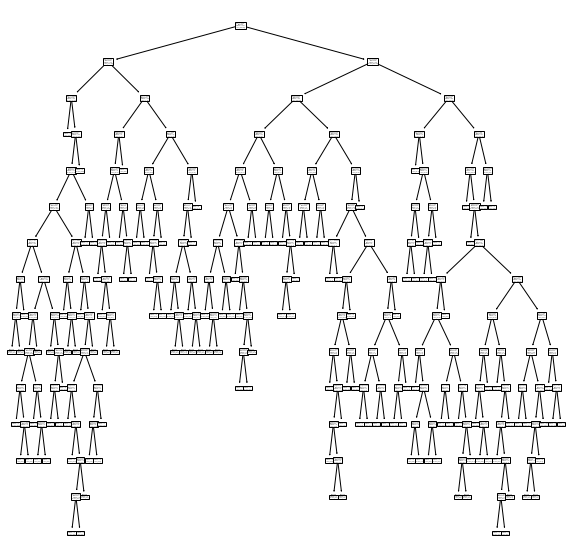

In [36]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(baseline_tree, ax=ax);

With a depth of 15, this model is far too complex and almost certainly overfit. Let's check the scores on the train and test data to see.

In [50]:
y_train_pred = baseline_tree.predict(X_train)
y_test_pred = baseline_tree.predict(X_test)

print('Baseline accuracy: ', baseline_tree.score(X_train, y_train))
print('Test accuracy: ', baseline_tree.score(X_test, y_test))
print('')
print('Baseline recall: ', recall_score(y_train, y_train_pred))
print('Test recall: ', recall_score(y_test, y_test_pred))

Baseline accuracy:  1.0
Test accuracy:  0.7583732057416268

Baseline recall:  1.0
Test recall:  0.7411167512690355


As expected, this model performs much worse on unseen data than on the training data for our key metrics. Let's try pruning it by reducing the max depth to improve our performance on the test set.

In [38]:
# instantiate pipeline
pruned_pipe = Pipeline([('scaler', StandardScaler()),
                        ('tree', DecisionTreeClassifier(criterion = 'gini', random_state = 270))])

# parameter grid
pruned_parameters = {'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

gs_pruned_pipe = GridSearchCV(estimator = pruned_pipe,
                                param_grid = pruned_parameters,
                                cv = 5)

In [39]:
gs_pruned_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=270))]),
             param_grid={'tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [40]:
grid_pruned_results = pd.DataFrame(gs_pruned_pipe.cv_results_)
grid_pruned_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004886,0.000254,0.001064,0.000119,2,{'tree__max_depth': 2},0.756972,0.733068,0.712,0.740,0.684,0.725208,0.025148,9
1,0.005484,0.000094,0.000905,0.000025,3,{'tree__max_depth': 3},0.752988,0.784861,0.740,0.780,0.776,0.766770,0.017286,2
2,0.006537,0.000119,0.000899,0.000029,4,{'tree__max_depth': 4},0.756972,0.752988,0.780,0.780,0.772,0.768392,0.011404,1
3,0.007881,0.000244,0.001048,0.000133,5,{'tree__max_depth': 5},0.760956,0.776892,0.732,0.776,0.748,0.758770,0.017104,4
4,0.008581,0.000053,0.000888,0.000003,6,{'tree__max_depth': 6},0.760956,0.768924,0.764,0.776,0.752,0.764376,0.008010,3
5,0.009600,0.000181,0.000965,0.000139,7,{'tree__max_depth': 7},0.780876,0.752988,0.744,0.780,0.720,0.755573,0.022991,8
6,0.010289,0.000117,0.000884,0.000005,8,{'tree__max_depth': 8},0.792829,0.764940,0.736,0.760,0.732,0.757154,0.022007,6
7,0.010907,0.000190,0.000876,0.000005,9,{'tree__max_depth': 9},0.792829,0.737052,0.748,0.780,0.724,0.756376,0.025995,7
8,0.011427,0.000250,0.000875,0.000003,10,{'tree__max_depth': 10},0.788845,0.752988,0.748,0.792,0.712,0.758767,0.029481,5


It seems like no matter where we prune the tree, there isn't a depth that is going to produce a strong result on unseen data. But somewhat surprisingly, the tree with a max depth of 4 performed the best on our test data. Perhaps we can utilize multiple simpler trees through a random forest model to take advantage of the power of an ensemble learning approach.

## Model 3: Random Forest

In [59]:
# instantiate random forest and pipeline
rf_decision = BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state=270), n_estimators = 435)
rf_pipe = Pipeline([('scaler', StandardScaler()),
                    ('model', rf_decision)])
rf_params = {'model__base_estimator__max_depth': np.arange(2,11,1)}
rf_cv = GridSearchCV(estimator = rf_pipe, param_grid = rf_params, cv = 5)

In [60]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=270),
                                                          n_estimators=435))]),
             param_grid={'model__base_estimator__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [74]:
best_rf_model = rf_cv.best_estimator_
rf_cv.best_params_

{'model__base_estimator__max_depth': 9}

In [62]:
rf_cv.best_score_

0.8418262948207171

In [63]:
pd.DataFrame(rf_cv.cv_results_)[['param_model__base_estimator__max_depth', 'mean_test_score', 'std_test_score']]

,param_model__base_estimator__max_depth,mean_test_score,std_test_score
0,2,0.785928,0.016291
1,3,0.813871,0.028707
2,4,0.820245,0.030447
3,5,0.826642,0.024810
4,6,0.829855,0.016468
5,7,0.831442,0.020965
6,8,0.833839,0.019569
7,9,0.841826,0.018202
8,10,0.840236,0.014281


It looks like for our random forest with 200 estimators, a max depth of 8 produces the best score on our validation folds. Let's try it out on our test data.

In [64]:
best_rf_model.fit(X_train, y_train)
y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       221
         1.0       0.78      0.79      0.78       197

    accuracy                           0.79       418
   macro avg       0.79      0.79      0.79       418
weighted avg       0.79      0.79      0.79       418



We've improved our performance on test data to about 79% for both accuracy and recall. Let's compare the random forest to our original logistic regression model.

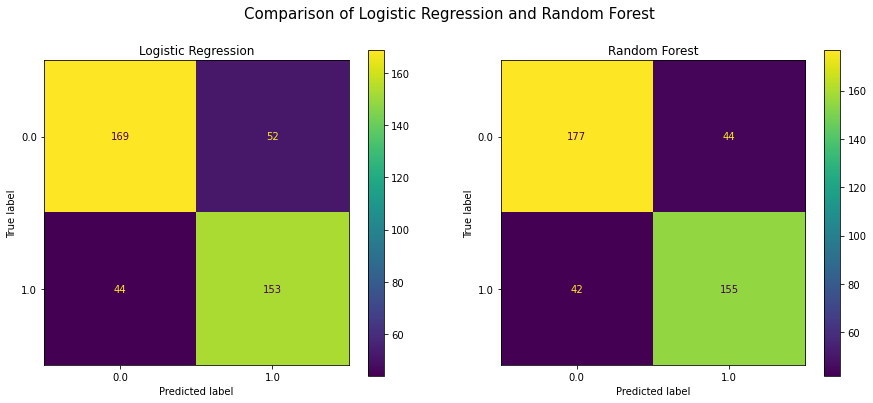

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression and Random Forest', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")

plot_confusion_matrix(baseline_pipe, X_test, y_test, ax=axes[0])
plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[1]);

In [125]:
print('Random forest precision: ', precision_score(y_test, y_pred_rf))
print('Logistic regression precision: ', precision_score(y_test, y_test_pred))
print('\n')
print('Random forest recall: ', recall_score(y_test, y_pred_rf))
print('Logistic regression recall: ', recall_score(y_test, y_test_pred))
print('\n')
print('Random forest accuracy: ', accuracy_score(y_test, y_pred_rf))
print('Logistic regression accuracy: ', accuracy_score(y_test, y_test_pred))
print('\n')
print('Random forest F1: ', f1_score(y_test, y_pred_rf))
print('Logistic regression F1: ', f1_score(y_test, y_test_pred))

Random forest precision:  0.7788944723618091
Logistic regression precision:  0.7448979591836735


Random forest recall:  0.7868020304568528
Logistic regression recall:  0.7411167512690355


Random forest accuracy:  0.7942583732057417
Logistic regression accuracy:  0.7583732057416268


Random forest F1:  0.7828282828282829
Logistic regression F1:  0.7430025445292621


## Model 4: XGBoost

In [119]:
xg_params = {'max_depth': [4,6,8], 'learning_rate': [.01, .1],
          'n_estimators': [150,200,250], 'gamma': [0, .4] }
xg_cv = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', random_state = 270), 
                     scoring='recall', param_grid = xg_params, cv = 5)
xg_cv.fit(X_train, y_train);

In [120]:
xg_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=270,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [121]:
xg_cv.best_score_

0.8642932074482035

In [122]:
best_xg_model = xg_cv.best_estimator_
best_xg_model.fit(X_train, y_train)
y_pred_xg = best_xg_mod.predict(X_test)

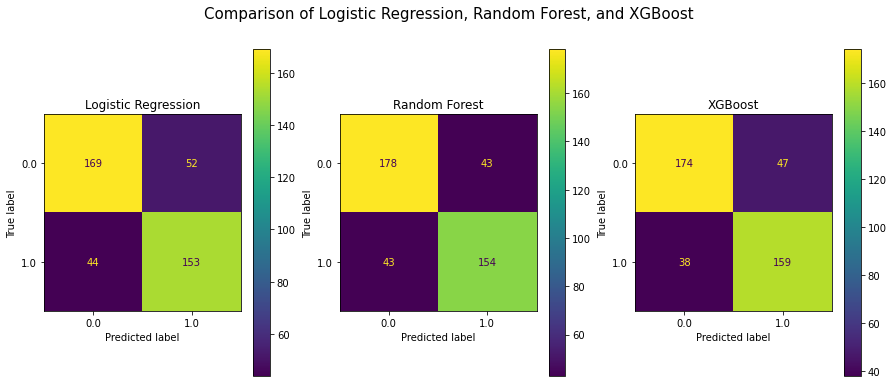

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

fig.suptitle('Comparison of Logistic Regression, Random Forest, and XGBoost', fontsize = 15)

axes[0].set_title("Logistic Regression")
axes[1].set_title("Random Forest")
axes[2].set_title("XGBoost")

plot_confusion_matrix(baseline_pipe, X_test, y_test, ax=axes[0])
plot_confusion_matrix(best_rf_model, X_test, y_test, ax=axes[1])
plot_confusion_matrix(best_xg_model, X_test, y_test, ax=axes[2]);

In [124]:
print('XGBoost precision: ', precision_score(y_test, y_pred_xg))
print('Random forest precision: ', precision_score(y_test, y_pred_rf))
print('Logistic regression precision: ', precision_score(y_test, y_test_pred))
print('\n')
print('XGBoost recall: ', recall_score(y_test, y_pred_xg))
print('Random forest recall: ', recall_score(y_test, y_pred_rf))
print('Logistic regression recall: ', recall_score(y_test, y_test_pred))
print('\n')
print('XGBoost accuracy: ', accuracy_score(y_test, y_pred_xg))
print('Random forest accuracy: ', accuracy_score(y_test, y_pred_rf))
print('Logistic regression accuracy: ', accuracy_score(y_test, y_test_pred))
print('\n')
print('XGBoost F1: ', f1_score(y_test, y_pred_xg))
print('Random forest F1: ', f1_score(y_test, y_pred_rf))
print('Logistic regression F1: ', f1_score(y_test, y_test_pred))

XGBoost precision:  0.7718446601941747
Random forest precision:  0.7788944723618091
Logistic regression precision:  0.7448979591836735


XGBoost recall:  0.8071065989847716
Random forest recall:  0.7868020304568528
Logistic regression recall:  0.7411167512690355


XGBoost accuracy:  0.7966507177033493
Random forest accuracy:  0.7942583732057417
Logistic regression accuracy:  0.7583732057416268


XGBoost F1:  0.7890818858560793
Random forest F1:  0.7828282828282829
Logistic regression F1:  0.7430025445292621


In [126]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80       221
         1.0       0.77      0.81      0.79       197

    accuracy                           0.80       418
   macro avg       0.80      0.80      0.80       418
weighted avg       0.80      0.80      0.80       418



## Feature Engineering: District Competitiveness, Census Regions

In [13]:
def calculate_percent_col(df, numerator_col, denominator_cols):
    ''' 
    A function that takes three arguments: a dataframe, a string for a column
    in the numerator, and a string or list for a column(s) in the denominator.
    
    It sums the values of the column(s) in the denominator and divides the value
    from the numerator column by that summed amount. It then multiplies that value
    by 100 to represent a percentage, and returns that value.
    '''
    denominator_sum = df[denominator_cols].sum(axis=1)
    percent_col = (df[numerator_col] / denominator_sum) * 100
    return percent_col

In [14]:
parties = ['republican', 'democrat', 'liberitarian', 'other', 'green']

In [15]:
# creating a percent republican column
pres_df['percent_rep'] = calculate_percent_col(pres_df, 'republican', parties)

# creating a percent democrat column
pres_df['percent_dem'] = calculate_percent_col(pres_df, 'democrat', parties)

In [16]:
pres_df.head(4)

,Year,County FIP Code,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Did Not Receive Foodstamps,% of Individuals Who Received Foodstamps,% of Females,% of Males,% Widowed,% Never Married,% Married Spouse Present,% Divorced,% Seperated,% Married Spouse Absent,% White,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Citizen,% Non-Citizen,% Naturalized Citizen,% English Is Spoken At Home,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Employed,% Not In The Labor Force,% Unemployed,state_po,county_name,democrat,green,liberitarian,other,republican,winner,percent_rep,percent_dem
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0,75.259479,23.811922
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0,65.691889,33.170870
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0,68.388582,30.169658
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0,47.067411,52.153370


In [17]:
# creating a percent margin column
pres_df['winning_margin'] = pres_df['percent_rep'] - pres_df['percent_dem']
pres_df.head(2)

,Year,County FIP Code,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Did Not Receive Foodstamps,% of Individuals Who Received Foodstamps,% of Females,% of Males,% Widowed,% Never Married,% Married Spouse Present,% Divorced,% Seperated,% Married Spouse Absent,% White,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Citizen,% Non-Citizen,% Naturalized Citizen,% English Is Spoken At Home,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Employed,% Not In The Labor Force,% Unemployed,state_po,county_name,democrat,green,liberitarian,other,republican,winner,percent_rep,percent_dem,winning_margin
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0,75.259479,23.811922,51.447558
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0,65.691889,33.170870,32.521019


In [18]:
pres_df.describe()

,Year,County FIP Code,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Did Not Receive Foodstamps,% of Individuals Who Received Foodstamps,% of Females,% of Males,% Widowed,% Never Married,% Married Spouse Present,% Divorced,% Seperated,% Married Spouse Absent,% White,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Citizen,% Non-Citizen,% Naturalized Citizen,% English Is Spoken At Home,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Employed,% Not In The Labor Force,% Unemployed,democrat,green,liberitarian,other,republican,winner,percent_rep,percent_dem,winning_margin
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1.670000e+03,1670.000000,1670.000000,1670.000000,1670.000000
mean,2014.194012,28717.220958,28841.084850,906.672635,46.903772,58749.243473,90.251257,9.748743,51.855629,48.144371,6.777066,25.837186,52.495150,11.105329,1.721317,2.062275,78.738683,9.917784,2.978862,3.136048,0.235689,3.035150,0.759401,0.928862,0.272455,88.969461,5.269042,5.761198,85.102335,14.897665,49.909222,38.882335,9.860778,1.347904,58.226347,38.028922,3.745689,1.158984e+05,167.460479,668.785629,4803.562275,8.568574e+04,0.488623,48.252009,48.924939,-0.672930
std,4.410969,15595.725527,7295.609512,291.128525,2.787388,14606.621299,4.952513,4.952513,1.830548,1.830548,1.559419,7.176813,7.509596,2.044045,0.766393,0.795502,14.646107,10.614890,3.912003,3.870875,1.090427,3.688328,2.406652,1.840668,0.680919,9.457760,4.631289,5.320845,13.393902,13.393902,5.909867,9.208955,4.384230,0.979554,6.558229,6.335632,1.373302,1.918876e+05,805.370013,2083.527700,10236.284021,9.659596e+04,0.500020,14.854136,14.849056,29.587523
min,2008.000000,1003.000000,14897.300000,421.100000,36.700000,34914.700000,65.600000,0.900000,33.400000,42.000000,2.500000,11.600000,26.800000,5.600000,0.000000,0.500000,18.600000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,44.800000,0.000000,0.000000,6.900000,1.400000,25.600000,13.000000,2.300000,0.000000,30.700000,20.800000,0.800000,2.474000e+03,0.000000,0.000000,0.000000,2.187000e+03,0.000000,4.087474,9.724106,-86.776347
25%,2012.000000,13135.000000,23894.650000,698.025000,45.200000,48357.400000,87.300000,6.100000,51.000000,47.100000,5.700000,20.900000,48.000000,9.625000,1.200000,1.500000,71.425000,2.625000,0.725000,1.100000,0.000000,1.000000,0.200000,0.200000,0.100000,86.400000,2.125000,2.200000,81.400000,6.200000,46.100000,32.300000,6.700000,0.700000,54.300000,33.700000,2.800000,2.843275e+04,0.000000,0.000000,756.250000,3.562700e+04,0.000000,39.189329,38.168029,-18.749241
50%,2016.000000,29099.000000,27351.850000,828.550000,46.900000,55458.800000,90.900000,9.100000,52.000000,48.000000,6.700000,24.900000,52.800000,11.100000,1.600000,1.950000,82.600000,6.400000,1.600000,1.700000,0.100000,1.900000,0.300000,0.400000,0.200000,92.200000,3.600000,3.900000,89.900000,10.100000,50.000000,38.800000,9.100000,1.100000,58.700000,37.500000,3.500000,5.305350e+04,0.000000,0.000000,1856.000000,5.448950e+04,0.000000,48.062352,48.838833,-0.756352
75%,2020.000000,42018.500000,32176.200000,1039.600000,48.400000,66187.150000,93.900000,12.700000,52.900000,49.000000,7.700000,29.400000,57.600000,12.400000,2.200000,2.500000,89.700000,13.300000,3.600000,3.700000,0.200000,3.600000,0.700000,0.900000,0.3

[Princeton defines "competitiveness zone" as districts where the Democratic and Republican vote share is between 46.5%-53.5%.](https://gerrymander.princeton.edu/redistricting-report-card-methodology) We will use a slightly expanded definition.

In [19]:
def rate_county(df, col):
    if col >= 12:
        return 'Safe R'
    if 5 < col < 12:
        return 'Lean R'
    if -5 <= col <= 5:
        return 'Swing'
    if -12 < col < -5:
        return 'Lean D'
    else:
        return 'Safe D'

In [20]:
pres_df['rating'] = pres_df['winning_margin'].apply(lambda x: rate_county(pres_df, x))

In [21]:
pres_df['rating'].value_counts()

Safe R    587
Safe D    572
Swing     216
Lean D    168
Lean R    127
Name: rating, dtype: int64

In [22]:
us_census_divisions = {
    'New England': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'Mid-Atlantic': ['NJ', 'NY', 'PA'],
    'East North Central': ['IL', 'IN', 'MI', 'OH', 'WI'],
    'West North Central': ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South Atlantic': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV'],
    'East South Central': ['AL', 'KY', 'MS', 'TN'],
    'West South Central': ['AR', 'LA', 'OK', 'TX'],
    'Mountain': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY'],
    'Pacific': ['AK', 'CA', 'HI', 'OR', 'WA']
}


In [23]:
def region_assignment(dic, val):
    for k, value in dic.items():
        if val in value:
            return k
        else:
            pass

In [24]:
region_assignment(us_census_divisions, 'NM')

'Mountain'

In [25]:
pres_df['census_region'] = pres_df['state_po'].apply(lambda x: region_assignment(us_census_divisions, x))

In [26]:
pres_df.head()

,Year,County FIP Code,Average Annual Income of Individuals,Average Amount Of Mortgage Payments,Average Age,Average Annual Total Family Income,% of Individuals Who Did Not Receive Foodstamps,% of Individuals Who Received Foodstamps,% of Females,% of Males,% Widowed,% Never Married,% Married Spouse Present,% Divorced,% Seperated,% Married Spouse Absent,% White,% Black/African American,% Other Race,% Two major Races,% Japanese,% Other Asian,% American Indian or Alaska Native,% Chinese,% Three or More Races,% Citizen,% Non-Citizen,% Naturalized Citizen,% English Is Spoken At Home,% Another Language Is Spoken At Home,% Some College or Bachelor Degree,% High School or Lower Education,% Masters or Professional Certificate,% Doctoral Degree,% Employed,% Not In The Labor Force,% Unemployed,state_po,county_name,democrat,green,liberitarian,other,republican,winner,percent_rep,percent_dem,winning_margin,rating,census_region
0,2008,1003,27222.4,902.2,48.6,53308.6,94.2,5.8,52.5,47.5,8.3,12.1,63.4,13.2,1.3,1.6,91.1,6.5,0.4,0.5,0.0,0.6,0.5,0.1,0.2,97.1,1.3,1.6,97.1,2.9,51.8,39.3,8.4,0.5,54.1,43.5,2.4,AL,BALDWIN,19386.0,0.0,0.0,756.0,61271.0,1.0,75.259479,23.811922,51.447558,Safe R,East South Central
1,2008,1015,20951.6,551.7,47.1,39712.5,89.1,10.9,54.8,45.2,8.7,19.5,54.5,11.5,3.0,2.8,80.5,17.1,0.1,0.9,0.1,0.7,0.3,0.2,0.0,97.3,1.5,1.2,95.4,4.6,41.1,52.6,5.0,1.2,54.3,41.1,4.5,AL,CALHOUN,16334.0,0.0,0.0,560.0,32348.0,1.0,65.691889,33.170870,32.521019,Safe R,East South Central
2,2008,1055,24017.6,658.6,48.2,47650.0,94.2,5.8,54.6,45.4,10.5,13.8,60.9,11.7,1.5,1.6,85.5,11.6,0.0,1.6,0.0,0.7,0.2,0.1,0.2,98.6,0.9,0.5,98.0,2.0,45.3,46.6,7.9,0.2,50.3,46.8,2.9,AL,ETOWAH,13497.0,0.0,0.0,645.0,30595.0,1.0,68.388582,30.169658,38.218924,Safe R,East South Central
3,2008,1073,28109.5,812.4,47.2,54993.2,93.5,6.5,55.0,45.0,9.5,23.5,50.3,12.3,2.5,1.9,63.1,35.1,0.4,0.7,0.0,0.5,0.1,0.1,0.0,97.5,1.3,1.2,96.6,3.4,47.8,42.0,9.3,0.9,58.5,38.1,3.4,AL,JEFFERSON,166121.0,0.0,0.0,2482.0,149921.0,0.0,47.067411,52.153370,-5.085959,Lean D,East South Central
4,2008,1081,24870.4,725.1,40.6,45575.0,92.4,7.6,52.1,47.9,4.9,32.1,51.2,8.3,1.7,2.0,75.2,21.0,0.3,0.6,0.1,1.7,0.3,0.8,0.2,94.4,4.1,1.5,93.2,6.8,53.3,32.2,10.8,3.7,59.8,36.3,3.8,AL,LEE,21498.0,0.0,0.0,597.0,32230.0,1.0,59.328118,39.572941,19.755177,Safe R,East South Central


In [27]:
pres_df['census_region'].value_counts()

South Atlantic        380
East North Central    310
Mid-Atlantic          235
Pacific               213
West South Central    194
West North Central    106
East South Central     94
Mountain               70
New England            64
Name: census_region, dtype: int64

In [ ]:
# parameter grid
baseline_parameters = {'lr__penalty': ['l1', 'l2'],
                       'lr__C'      : [.01, .1, 1, 10, 100, 1000]}

gs_baseline_pipe = GridSearchCV(estimator = baseline_pipe,
                                param_grid = baseline_parameters,
                                cv = 5)

In [ ]:
gs_baseline_pipe.fit(X_train, y_train)

In [ ]:
grid_baseline_results = pd.DataFrame(gs_baseline_pipe.cv_results_)
grid_baseline_results